## 1. Import libraries 

In [2]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans 
import xgboost

***

## 2. Import data 

In [4]:
folder_path = '../'
train_path = os.path.join(folder_path,'train.csv') 
test_path = os.path.join(folder_path, 'test.csv')

In [5]:
df_train = pd.read_csv(train_path)

***

## 3. Data Exploration 

### 3.1 Preliminary Data Scan 

In [6]:
df_train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [8]:
# Get all the non-numeric variables and ascertain unique values
categorical_variables = ['state','area_code','international_plan','voice_mail_plan']
df_train[categorical_variables].nunique()

state                 51
area_code              3
international_plan     2
voice_mail_plan        2
dtype: int64

**Independent variables** <br>
Thus there are two categorical variables, two binary variables and fourteen continuous numerical variables. 

**Dependent variable** <br>
The target variable 'churn' is also binary i.e. 'Yes' or 'No' 

***

### 3.2 Exploratory Data Analysis (Plots)

In [9]:
# Before we look at possible relationships lets add a new column\
# 'churn_rate' that stores values of 'churn' but converted to integer i.e. "yes" = 1, "no" = 0
df_train['churn_rate'] = df_train['churn'].map({'yes':1, 'no':0})

##### Categorical variable : international_plan 

<IPython.core.display.Javascript object>


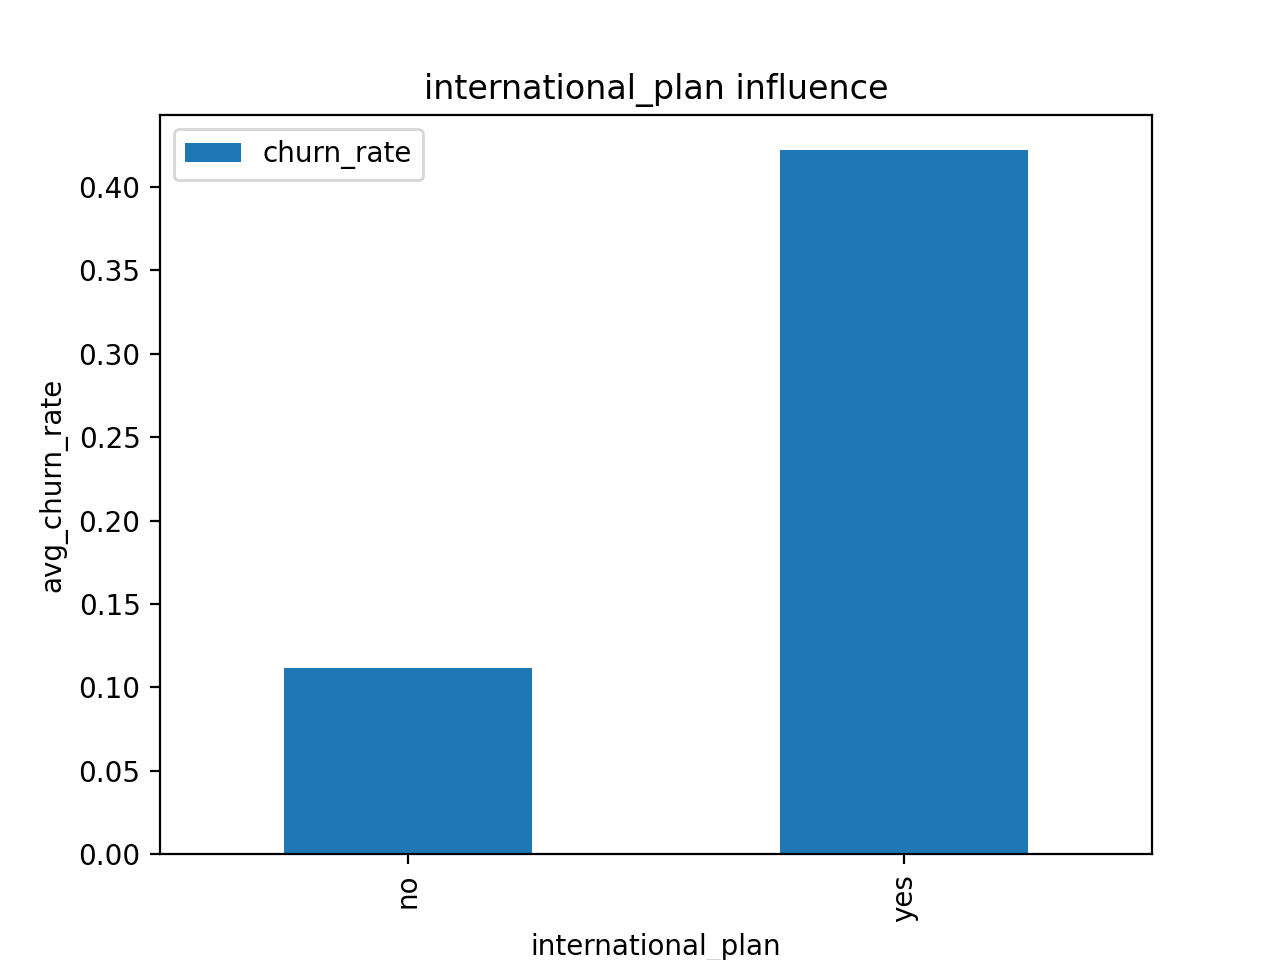

In [75]:
df_train.groupby('international_plan')['churn_rate'].mean().reset_index().plot.bar(x='international_plan',y='churn_rate')
plt.ylabel('avg_churn_rate')
plt.title('international_plan influence')
plt.show()

##### Categorical variable : voice_mail_plan

<IPython.core.display.Javascript object>


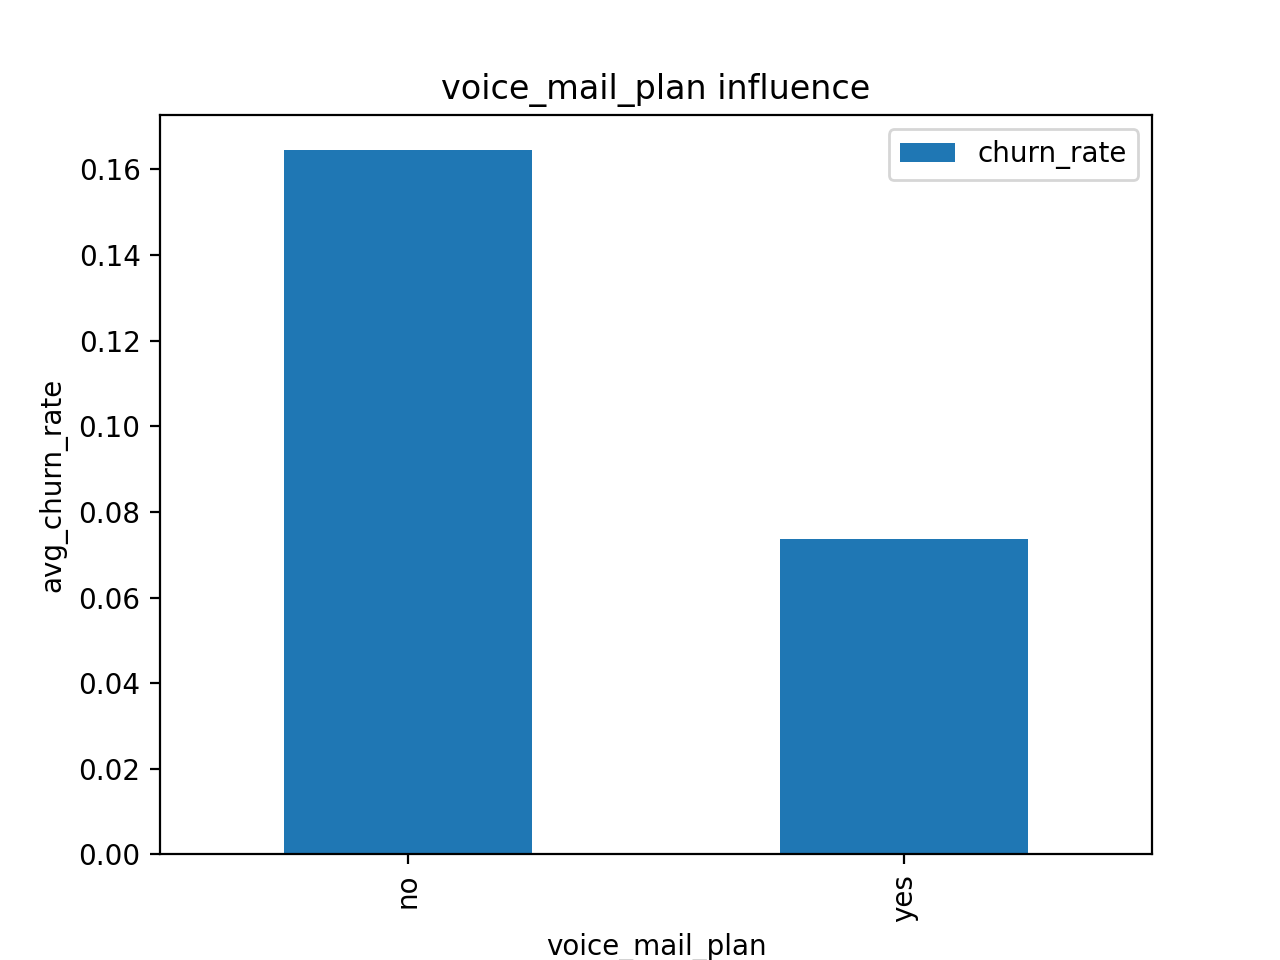

In [76]:
df_train.groupby('voice_mail_plan')['churn_rate'].mean().reset_index().plot.bar(x='voice_mail_plan',y='churn_rate')
plt.ylabel('avg_churn_rate')
plt.title('voice_mail_plan influence')
plt.show()

##### Categorical variable : area_code 

<IPython.core.display.Javascript object>


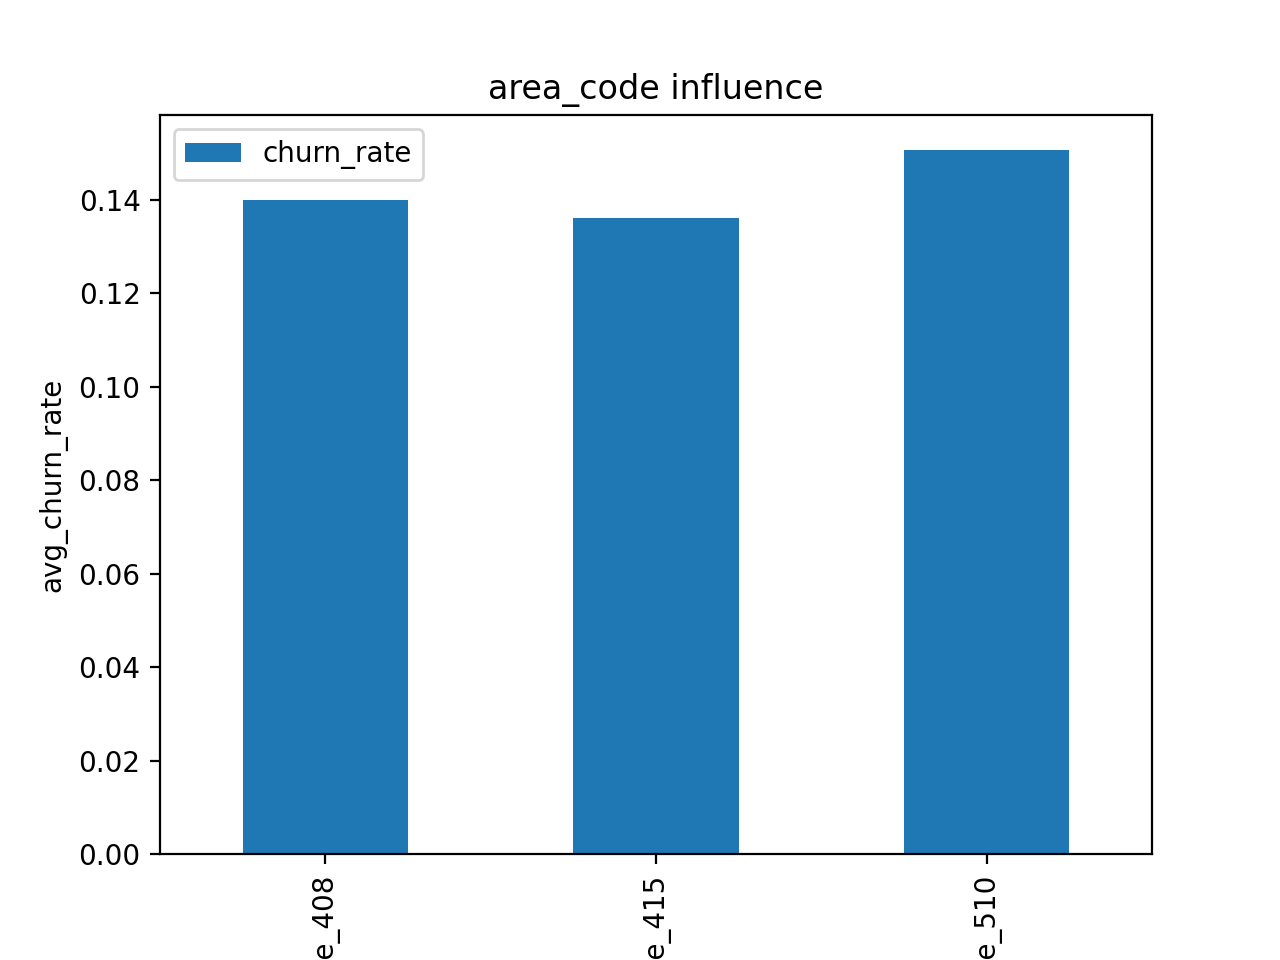

In [77]:
df_train.groupby('area_code')['churn_rate'].mean().reset_index().plot.bar(x='area_code',y='churn_rate')
plt.ylabel('avg_churn_rate')
plt.title('area_code influence')
plt.show()

##### Categorical variable : state 

<IPython.core.display.Javascript object>


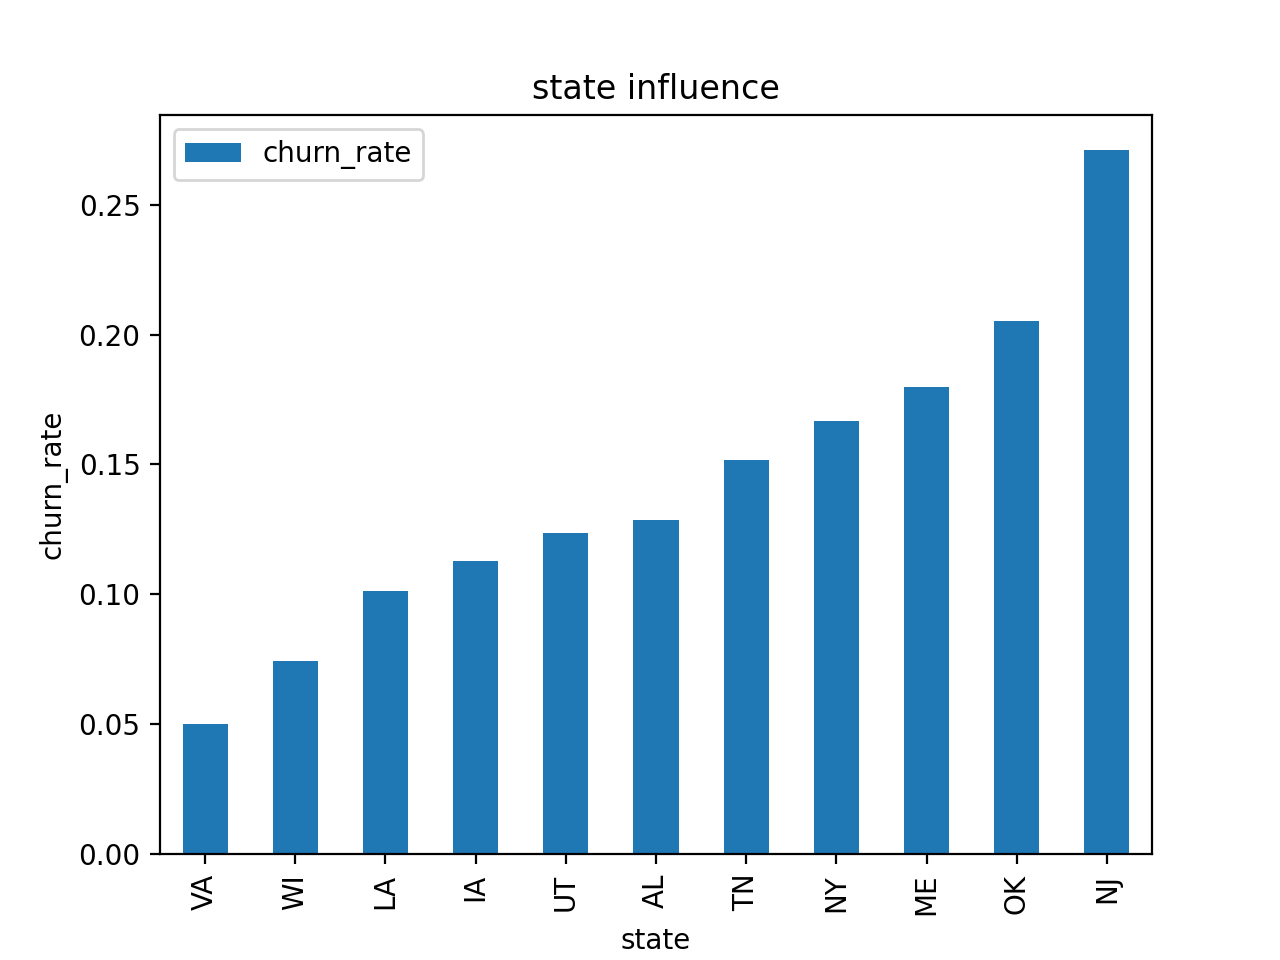

In [81]:
df_train.groupby('state')['churn_rate'].mean().sort_values()[::5].reset_index().plot.bar(x='state',y='churn_rate')
plt.ylabel('churn_rate')
plt.title('state influence')
plt.show()
# plot every five states to avoid clutter 

> *Comment*: Thus it appears all categorical variables but area_code are relatively good discriminators of churn

##### Numerical variable : # of Customer Service Calls 

<IPython.core.display.Javascript object>


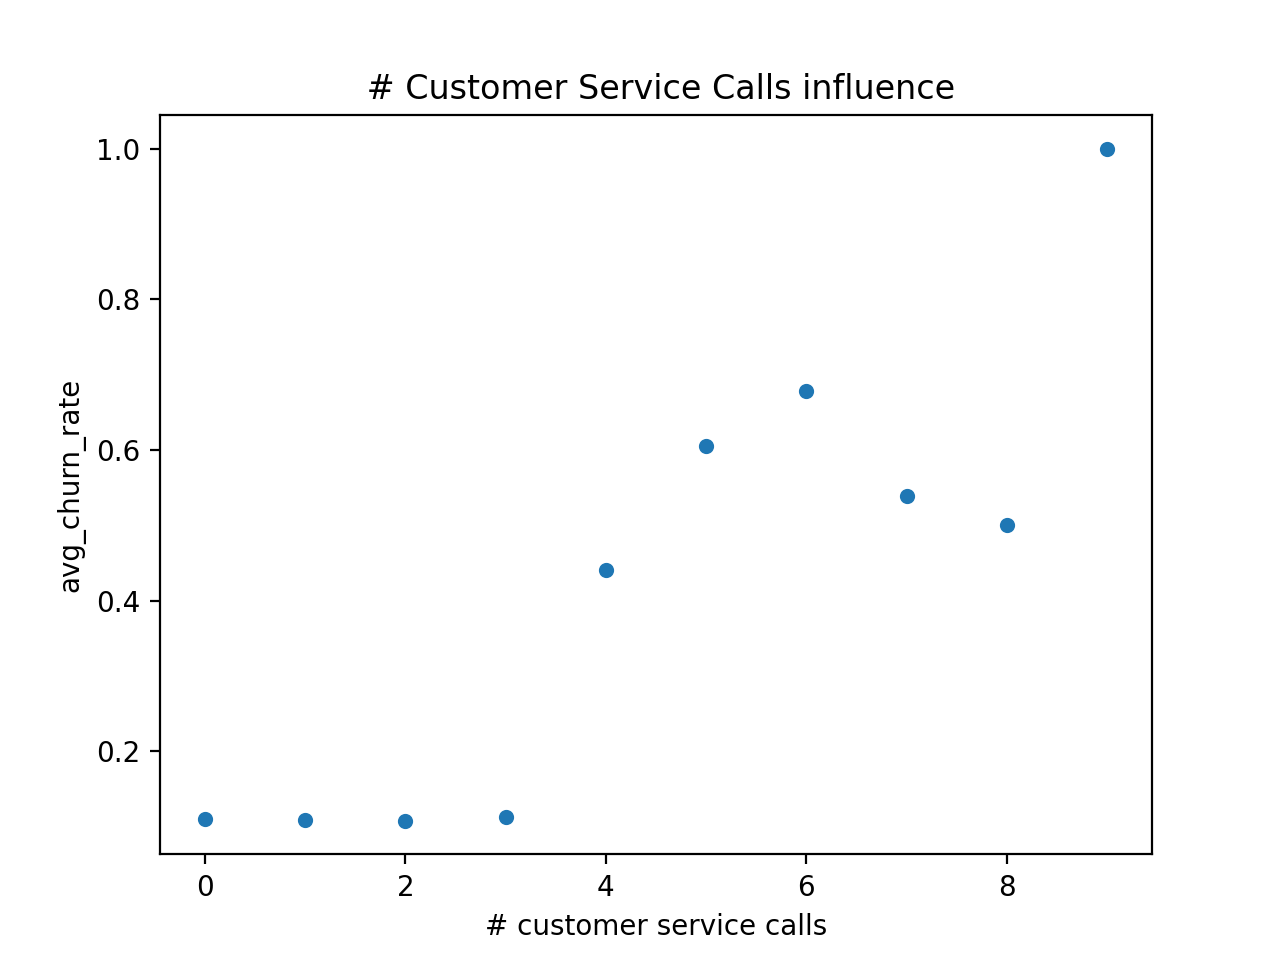

In [119]:
df_train.groupby(['number_customer_service_calls'])['churn_rate'].mean().reset_index().plot.scatter(x='number_customer_service_calls',y='churn_rate')
plt.title(' # Customer Service Calls influence')
plt.xlabel('# customer service calls')
plt.ylabel('avg_churn_rate')
plt.show()

> _Comment_: This makes sense because a high number of customer service calls (complaints) implies either: 
> 1. customer grievances have not been adequately addressed after a few calls (< 3)
> 2. recurring problems necessitating multiple call complaints 

> *Comment*: Before we look at the remaining numerical variables it is prudent to transform them to $charge/calls$ or $charge/min$ since absolute values convey little information

In [25]:
for call_type in ['day','eve','night','intl']:
    df_train[call_type+'_charge_per_min'] = round(df_train['total_'+call_type+'_minutes']/df_train['total_'+call_type+'_charge'],1)
    df_train[call_type+'_charge_per_calls'] = round(df_train['total_'+call_type+'_calls']/df_train['total_'+call_type+'_charge'],1)


<IPython.core.display.Javascript object>


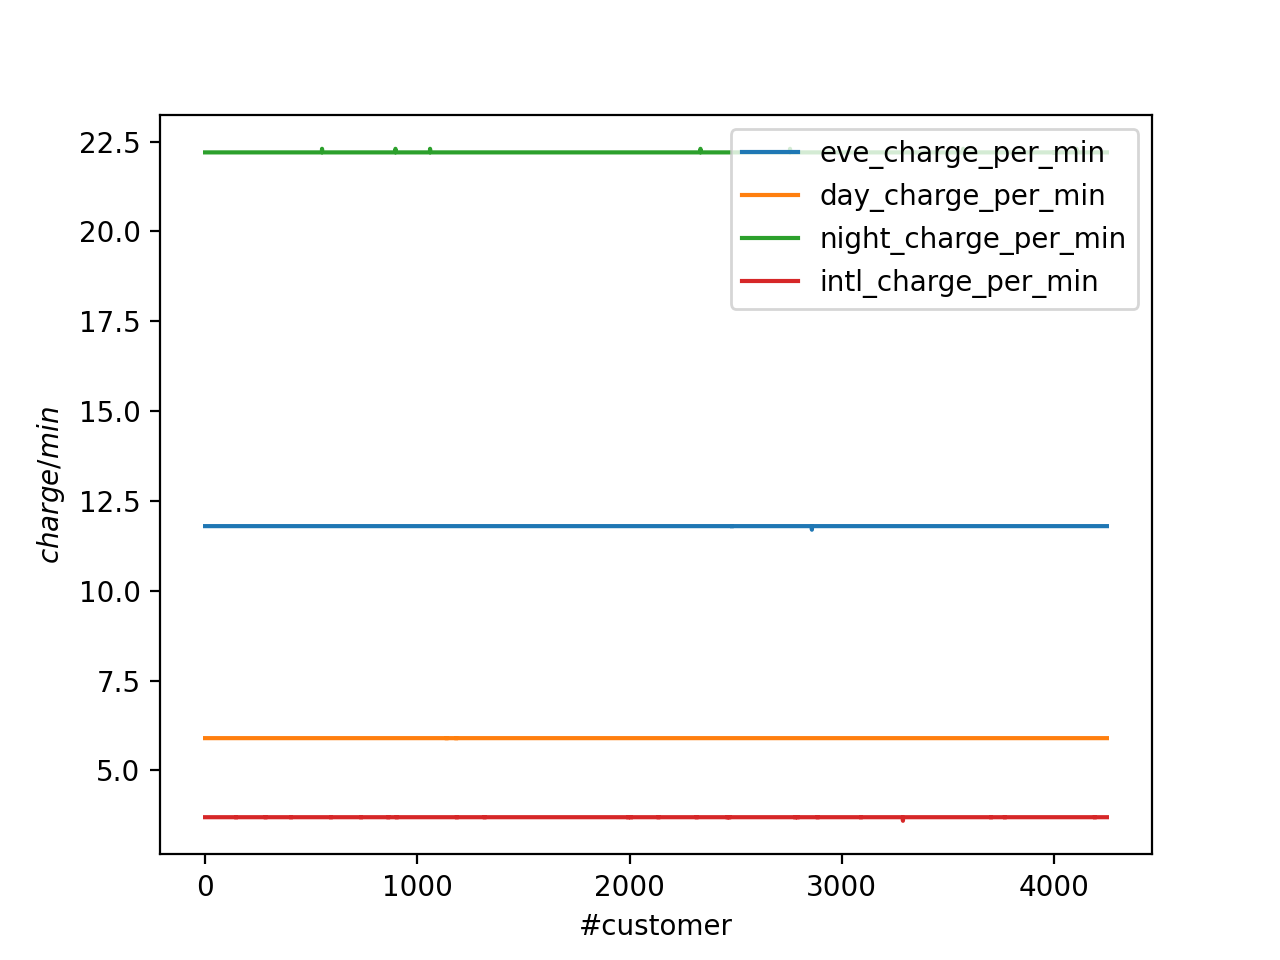

In [122]:
df_train[['eve_charge_per_min','day_charge_per_min','night_charge_per_min','intl_charge_per_min']].plot()
plt.ylabel('$charge/min$')
plt.xlabel('#customer')
plt.show()

> *Comment* : My initial supposition about $charge/min$ being informative was __erroneous__ as observed by the plot above. Moreover this makes sense because the $charge/min$ should be the same for all customers. Also $charge/call$ is meaningless since the extent of any call (how many mins ?) is unknown. <font color=red>Watch this space for improvements (should I have an epiphany)</font>

> Thus all '*charge_per*' columns created above will be removed

In [35]:
df_train.drop([col for col in df_train.columns.to_list() if 'charge_per' in col],axis=1, inplace=True)

***

## 4. Data Preperation : Encoding categorical columns

In [13]:
oe = OrdinalEncoder()
oe = oe.fit(df_train[categorical_variables]) # Ordinal encoder object 'oe' contains the encoding information \
# which is vital during testing as well as retrieval of original labels

categorical_encoded = oe.transform(df_train[categorical_variables])

In [23]:
df_train.loc[:,categorical_variables] = categorical_encoded

***

## 5. Baseline prediction performance

> *Comment* : Lets use the features as is (i.e. minimal transformation) to build a predictor and observe performance. Subsequent improvements will involve transforming a few columns to (hopefully) yield a better performance.

> Lets start by gauging the significance and impact of features 

### 5.1 Initial hint at relevance of features : Logistic Regression

In [211]:
glm_variables = df_train.drop(columns=['churn','churn_rate'],axis=1).columns.to_list()

glm_model = sm.GLM(df_train['churn_rate'],df_train[glm_variables] )
res = glm_model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             churn_rate   No. Observations:                 4250
Model:                            GLM   Df Residuals:                     4231
Model Family:                Gaussian   Df Model:                           18
Link Function:               identity   Scale:                        0.099967
Method:                          IRLS   Log-Likelihood:                -1127.3
Date:                Fri, 19 Mar 2021   Deviance:                       422.96
Time:                        00:59:05   Pearson chi2:                     423.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
international_

> *Comment* : From logitic regression we can see that features like international_plan, voice_mail_plan, number_customer_service_calls etc. are very significant since their p_values ($P>|z|$) are << 0.05 . Also the impact of features can be ascertained by considering observing the magnitude of coefficients , seen below  by taking the exponent of log coefficients

In [212]:
np.exp(res.params).sort_values(ascending=False)

total_day_minutes                1.797326
total_eve_charge                 1.491331
international_plan               1.350418
total_intl_minutes               1.137321
number_customer_service_calls    1.057332
total_night_minutes              1.032436
number_vmail_messages            1.002005
account_length                   0.999948
state                            0.999728
total_day_calls                  0.999459
total_eve_calls                  0.999103
total_night_calls                0.999070
area_code                        0.993881
total_intl_calls                 0.992953
total_eve_minutes                0.966919
voice_mail_plan                  0.859563
total_intl_charge                0.628668
total_night_charge               0.493753
total_day_charge                 0.031999
dtype: float64

> *Comment* : As seen above features like international_plan, total_day_minutes, total_eve_charge affect churn the most. Ultimately the best features are those that are significant and impactful 

### 5.2 Model fitting with XGBoost

> *Comment* : Lets split df_train into train and test. Reason this data frame is called df_train is because after model fitting we will use all the data in df_train to train the model (final step). __There is a yet unseen (test) dataset which we will use for final model evaluation.__


In [84]:
X = df_train.drop(['churn','churn_rate'], axis = 1)
y = df_train['churn_rate']

# And now splitting into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=25 )

In [90]:
# Fitting the model
xgb_model = xgboost.XGBClassifier(max_depth = 3, 
                              learning_rate = 0.08, 
                              objective = 'binary:logistic' ,n_jobs=-1).fit(X_train, y_train)

print('Training accuracy: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Testing accuracy: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

[15:42:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training accuracy: 0.97
Testing accuracy: 0.96


> *Comment* : Reducing the maximum depth of each tree from 4 to 3 lowered the training accuracy by 1% but didn't significantly change the test accuracy. Thus sticking to maximum tree depth of 3

In [97]:
# Lets take a closer look at performance
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       563
           1       0.91      0.69      0.79        75

    accuracy                           0.96       638
   macro avg       0.94      0.84      0.88       638
weighted avg       0.95      0.96      0.95       638



> *Comment* : Notice the recall rate when churn does happen (i.e. churn = 1) is comparatively low (69%) meaning the model is __missing__ an appreciable number of __actually__ churned customers. Lets investigate further if there is room for improvement

<IPython.core.display.Javascript object>


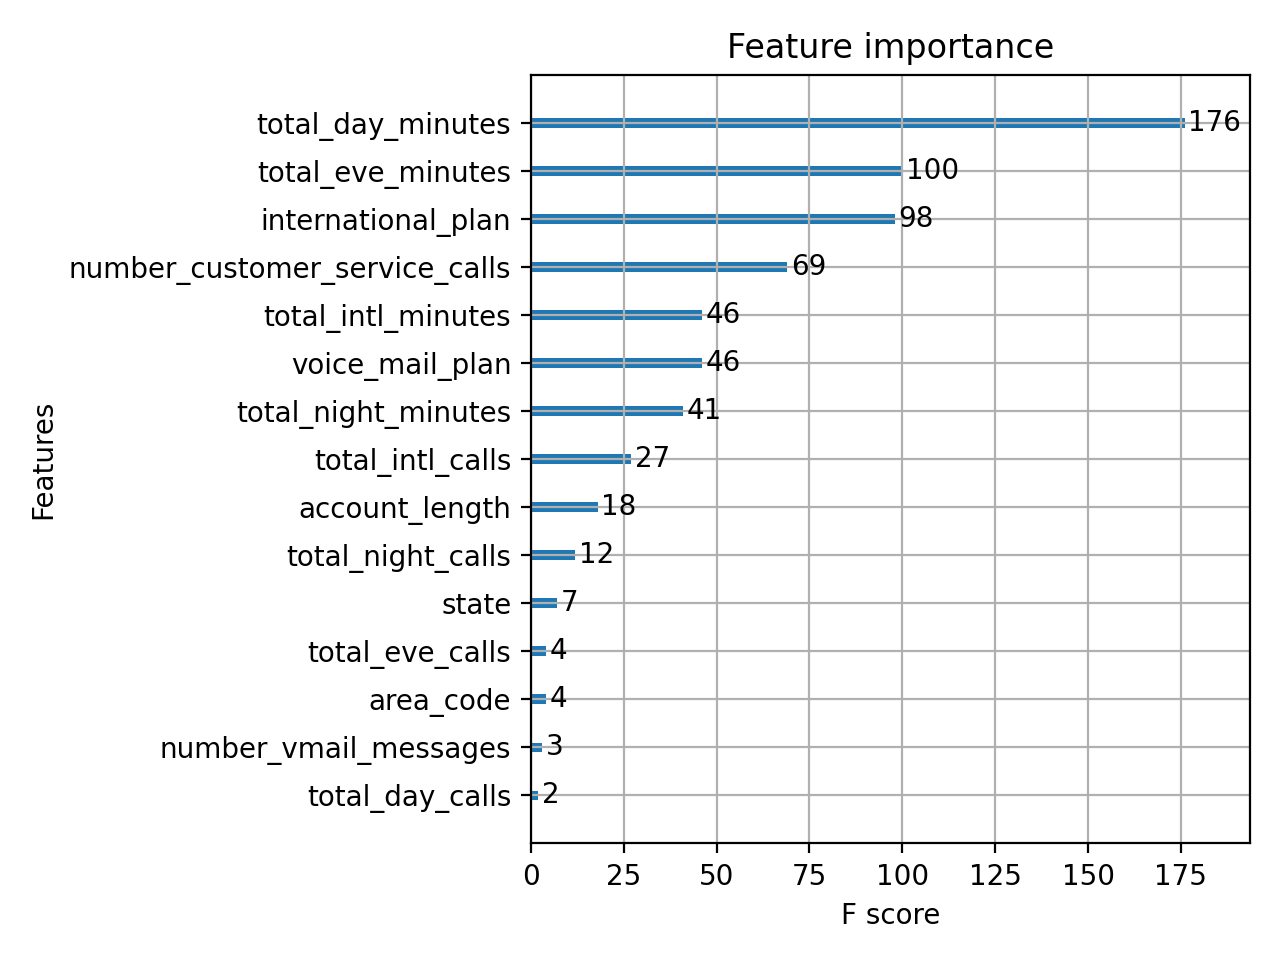

In [104]:
xgboost.plot_importance(xgb_model)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


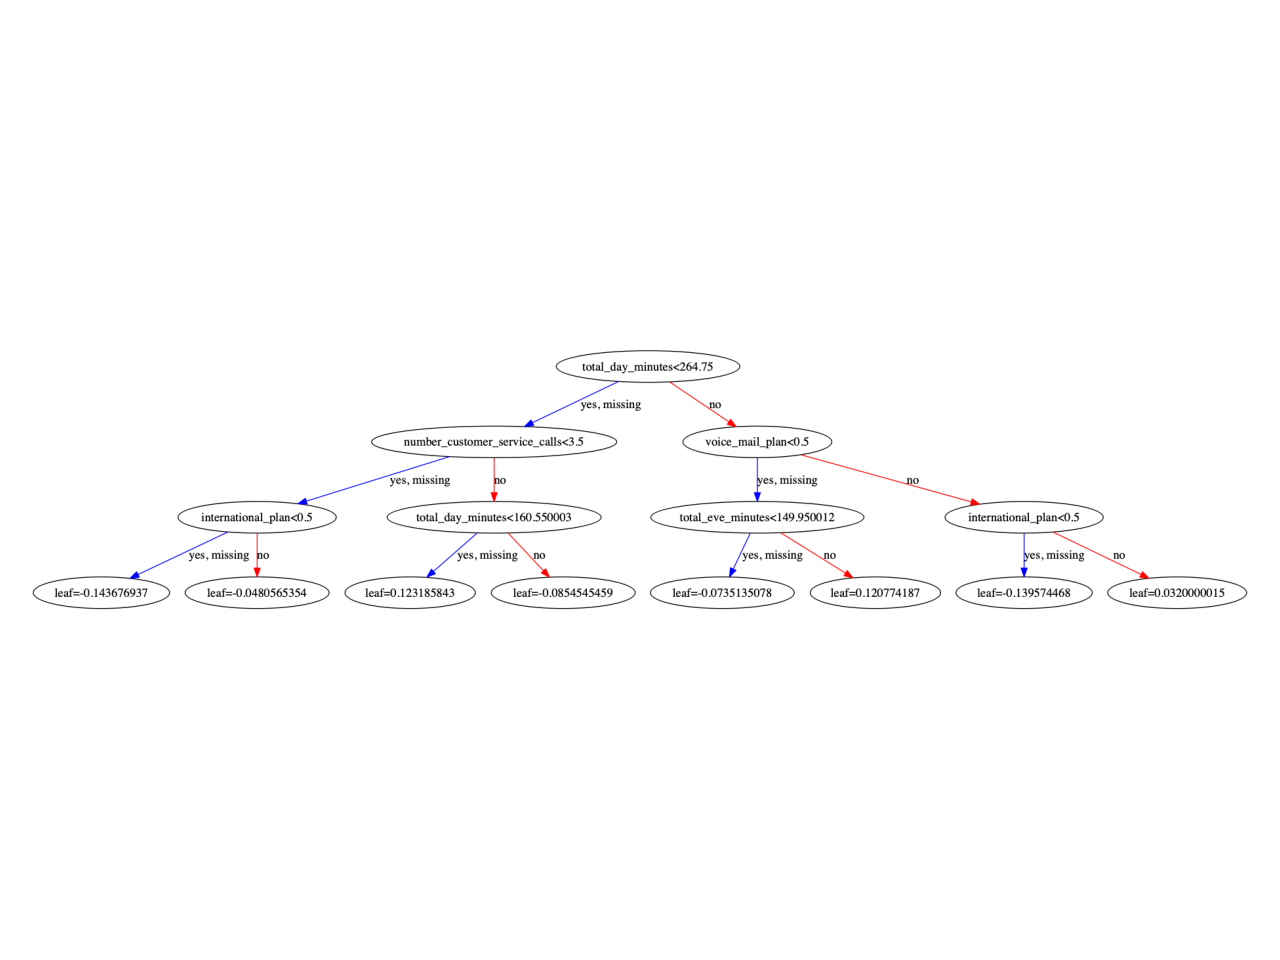

In [105]:
xgboost.plot_tree(xgb_model)
plt.tight_layout()
plt.show()

## 6. Improve prediction performance: clustering  

> *Comment* : 
> 1. We've established a baseline of performance. Lets explore ways to improve the predictive ability specifically the recall rate when a customer churns

> 2. The continuous numeric features perhaps have noise  and a good way to extract more information indeed a clearer way of explanation is to cluster them.


### 6.1 Clustering : Elbow method

> *Comment* : Elbow method is a way to find the optimal number of clusters

In [123]:
numerical_variables = df_train.drop(categorical_variables+['churn','churn_rate','number_customer_service_calls'],axis=1).columns.to_list()
df_cluster = pd.DataFrame(index=range(1,11))
for col in numerical_variables:
    df_cluster[col+'_cluster'] = np.NaN
    for k in range(1,11):
        cluster = KMeans(n_clusters=k, max_iter=400).fit(df_train[[col]])
        df_cluster.loc[k,col+'_cluster'] = cluster.inertia_

<IPython.core.display.Javascript object>


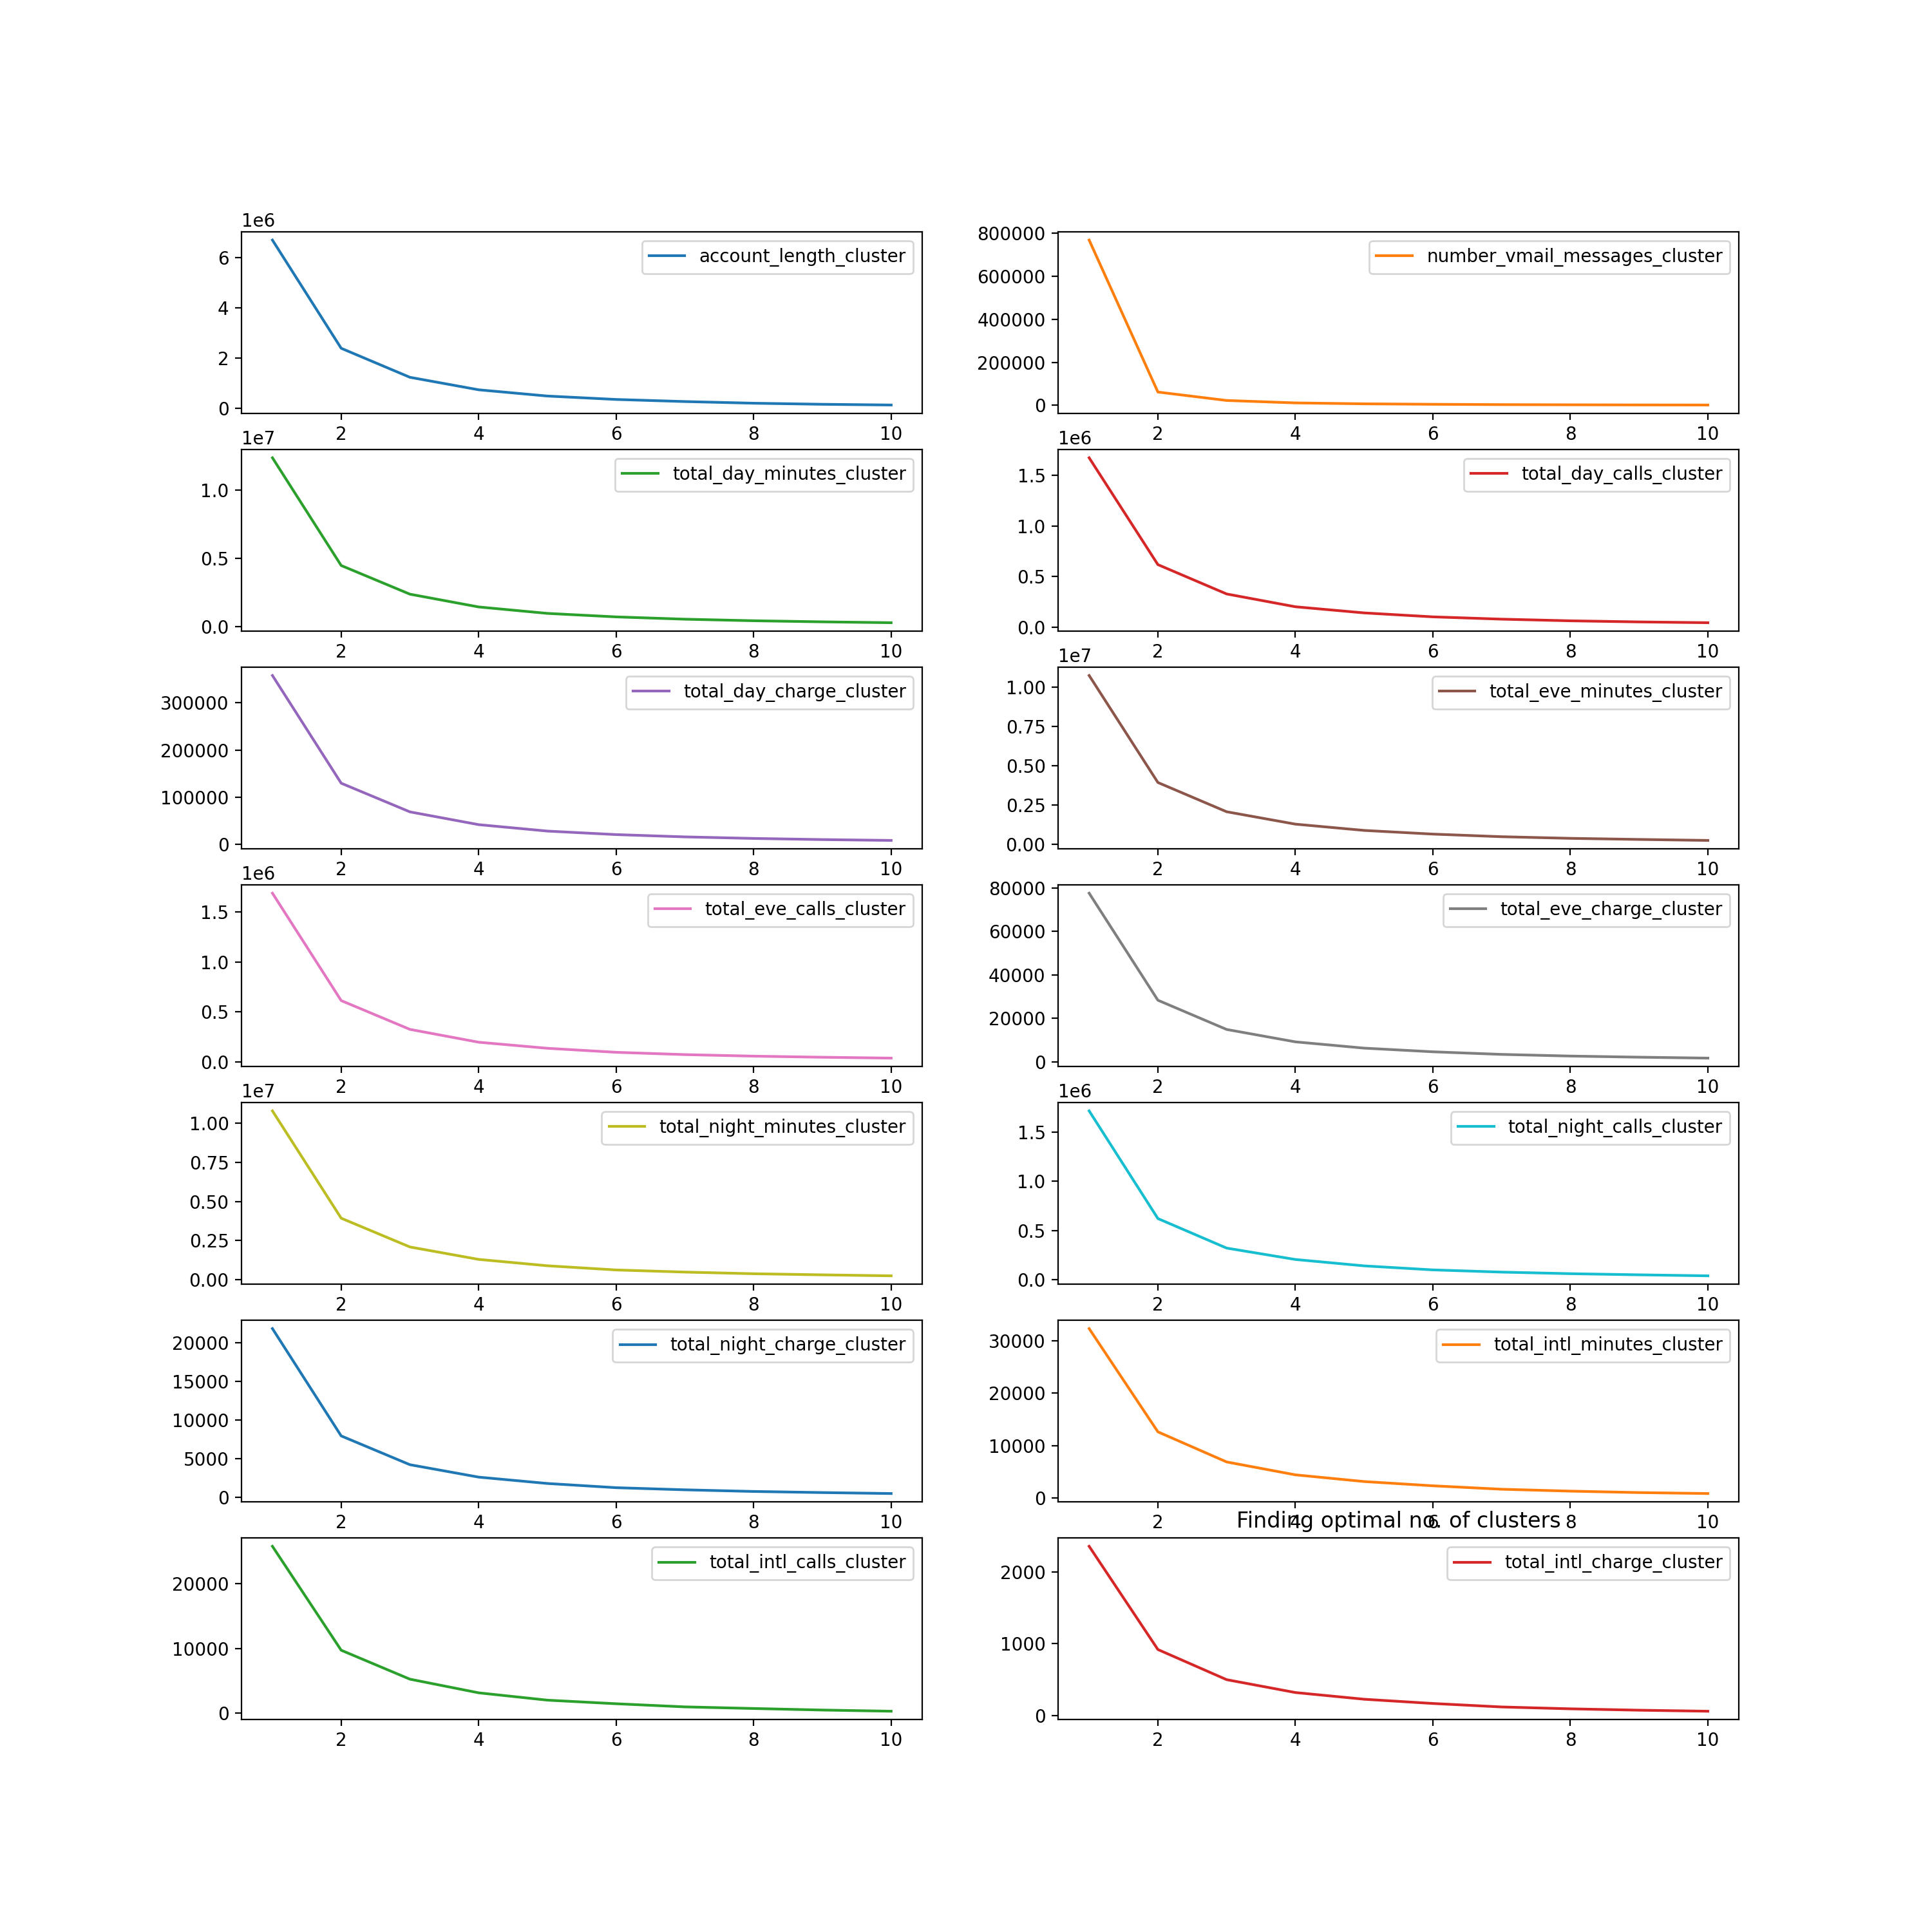

In [197]:
df_cluster.plot(subplots=True, layout=(7,2), figsize=(15,15), sharex=False)
plt.show()

> *Comment* : But for number_vmail_messages all other features are optimally clustered with 4 centroids. number_vmail_messages clusters best with 2 centroids.  

In [193]:
# Doing the needful by creating extra columns s.t. each numerical feature gets a _cluster counterpart
for col in df_train[numerical_variables]:
    if col != 'number_vmail_messages':
        cluster = KMeans(n_clusters = 4, max_iter=400).fit(df_train[[col]])
        df_train[col+'_cluster'] = cluster.predict(df_train[[col]])
        
    else:
        cluster = KMeans(n_clusters = 2, max_iter=400).fit(df_train[[col]])
        df_train[col+'_cluster'] = cluster.predict(df_train[[col]])

In [194]:
df_train.groupby('account_length_cluster')['account_length'].mean()

account_length_cluster
0     45.590962
1    123.324159
2     87.190132
3    166.050089
Name: account_length, dtype: float64

> *Comment* : Notice how the cluster# has no association with centroid magnitudes. This needs to be remedied otherwise information is lost

In [195]:
# Sorting and renaming cluster# according to centroid magnitudes  
for col in numerical_variables:
    idx = df_train.groupby(col+'_cluster')[col].mean().sort_values().index.to_list()
    df_train[col+'_cluster'].replace(idx, list(range(len(idx))), inplace = True)

In [196]:
df_train.groupby('account_length_cluster')['account_length'].mean()

account_length_cluster
0     45.590962
1     87.190132
2    123.324159
3    166.050089
Name: account_length, dtype: float64

> *Comment* : And now the cluster# aligns with the centroid magnitudes

### 6.2 Hint at relevant features: Logistic Regression 

In [199]:
# Removing numerical features and replacing with _cluster counterparts
glm_variables = df_train.drop(numerical_variables+['churn','churn_rate'],axis=1).columns.to_list()

glm_model = sm.GLM(df_train['churn_rate'],df_train[glm_variables], family = sm.families.Binomial())
res = glm_model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             churn_rate   No. Observations:                 4250
Model:                            GLM   Df Residuals:                     4231
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1541.9
Date:                Fri, 19 Mar 2021   Deviance:                       3083.7
Time:                        00:48:57   Pearson chi2:                 4.41e+03
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
state         

In [204]:
np.exp(res.params).sort_values(ascending=False)

number_vmail_messages_cluster    1.184513e+09
international_plan               6.587211e+00
total_intl_minutes_cluster       5.045719e+00
total_day_minutes_cluster        2.922972e+00
total_night_minutes_cluster      1.803958e+00
total_eve_charge_cluster         1.618500e+00
number_customer_service_calls    1.390517e+00
state                            9.831364e-01
account_length_cluster           8.218509e-01
total_day_calls_cluster          8.004863e-01
total_intl_calls_cluster         7.638164e-01
total_night_calls_cluster        7.530592e-01
total_eve_calls_cluster          7.408761e-01
area_code                        7.393231e-01
total_eve_minutes_cluster        6.090053e-01
total_night_charge_cluster       5.210163e-01
total_day_charge_cluster         4.538127e-01
total_intl_charge_cluster        1.728960e-01
voice_mail_plan                  2.565419e-10
dtype: float64

### 6.3 Model fitting with XGBoost 

In [213]:
X = df_train.drop(['churn','churn_rate']+numerical_variables, axis=1)
y = df_train['churn_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=25 )

In [226]:
xgb_model = xgboost.XGBClassifier(objective='binary:logistic',
                                 max_depth = 3, learning_rate=0.08, n_jobs=-1).fit(X_train, y_train)

print("Training accuracy : {:.2f}".format(xgb_model.score(X_train, y_train)))
print("Testing accuracy : {:.2f}".format(xgb_model.score(X_test[X_train.columns], y_test)))

[01:23:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training accuracy : 0.93
Testing accuracy : 0.92


In [222]:
# Lets take a closer look at performance
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       563
           1       0.74      0.49      0.59        75

    accuracy                           0.92       638
   macro avg       0.84      0.74      0.77       638
weighted avg       0.91      0.92      0.91       638



> *Comment* : Thus clustering numerical features did not help improve accuracy. Infact the recall of churned customers is poorer than before

<IPython.core.display.Javascript object>


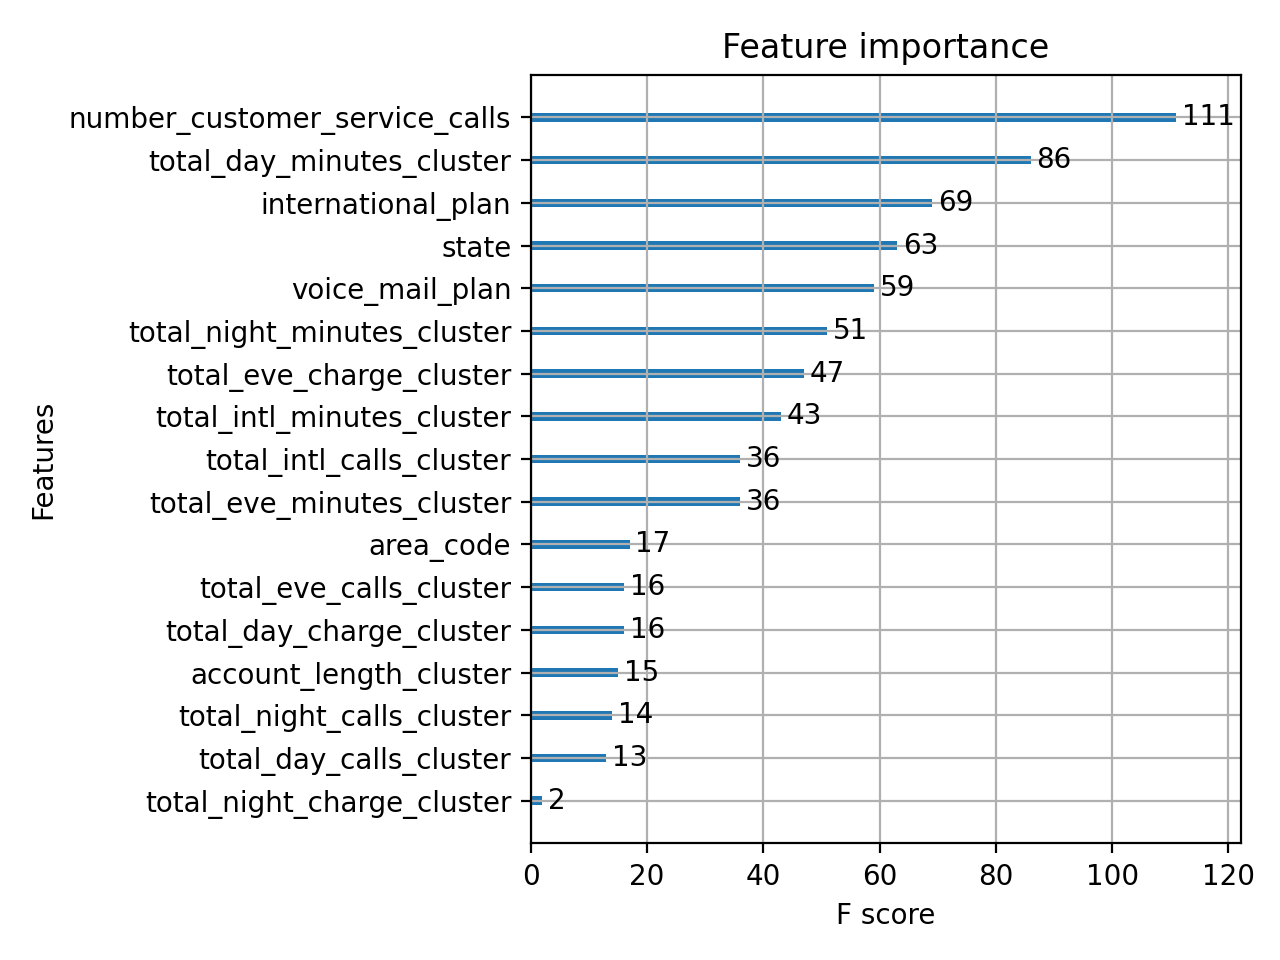

In [223]:
xgboost.plot_importance(xgb_model)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


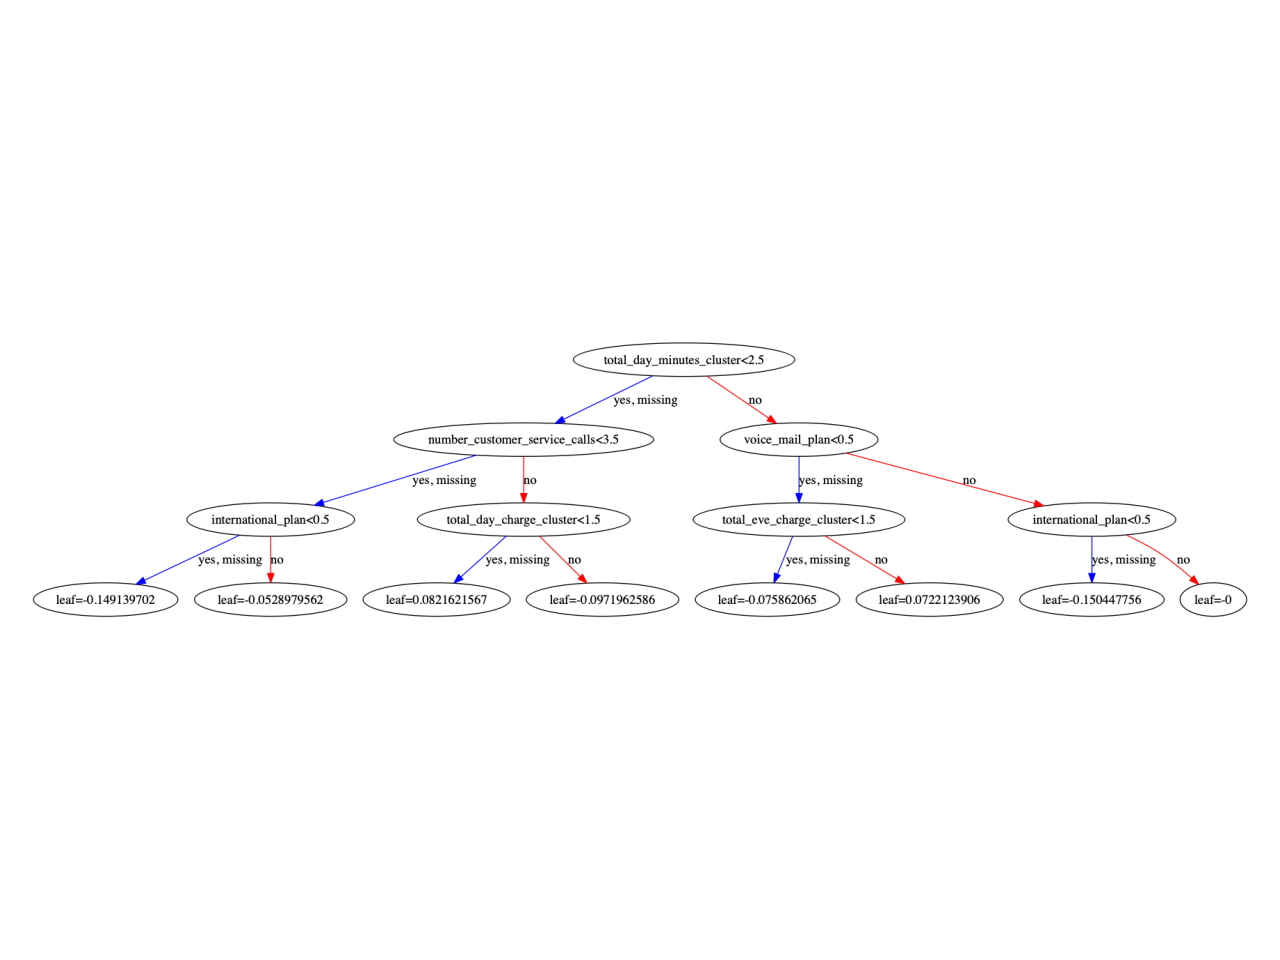

In [224]:
xgboost.plot_tree(xgb_model)
plt.tight_layout()
plt.show()